In [16]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

In [18]:
mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

In [19]:
batch_size = 128
cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [20]:
%matplotlib inline
from genereateTriplets import TripletMNIST


In [21]:
triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)


In [22]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [23]:
from models import EncoderNet, TripletNet
from loss import TripletLoss

In [24]:
encoder = EncoderNet()
model = TripletNet(encoder)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

TripletNet(
  (encoder_net): EncoderNet(
    (convnet): Sequential(
      (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (1): PReLU(num_parameters=1)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (4): PReLU(num_parameters=1)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=256, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): PReLU(num_parameters=1)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
)

In [25]:
loss_fn = TripletLoss(margin=1)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [26]:
from train import fit
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.999559
Train: [12800/60000 (21%)]	Loss: 0.294313
Train: [25600/60000 (43%)]	Loss: 0.160945
Train: [38400/60000 (64%)]	Loss: 0.109800
Train: [51200/60000 (85%)]	Loss: 0.085008
Epoch: 1/20. Train set: Average loss: 0.1533
Epoch: 1/20. Validation set: Average loss: 0.0689
Train: [0/60000 (0%)]	Loss: 0.053820
Train: [12800/60000 (21%)]	Loss: 0.063812
Train: [25600/60000 (43%)]	Loss: 0.058146
Train: [38400/60000 (64%)]	Loss: 0.048867
Train: [51200/60000 (85%)]	Loss: 0.044472
Epoch: 2/20. Train set: Average loss: 0.0547
Epoch: 2/20. Validation set: Average loss: 0.0442
Train: [0/60000 (0%)]	Loss: 0.035584
Train: [12800/60000 (21%)]	Loss: 0.035052
Train: [25600/60000 (43%)]	Loss: 0.032937
Train: [38400/60000 (64%)]	Loss: 0.029941
Train: [51200/60000 (85%)]	Loss: 0.033419
Epoch: 3/20. Train set: Average loss: 0.0340
Epoch: 3/20. Validation set: Average loss: 0.0347
Train: [0/60000 (0%)]	Loss: 0.007264
Train: [12800/60000 (21%)]	Loss: 0.028121
Train: [25600/60000 (

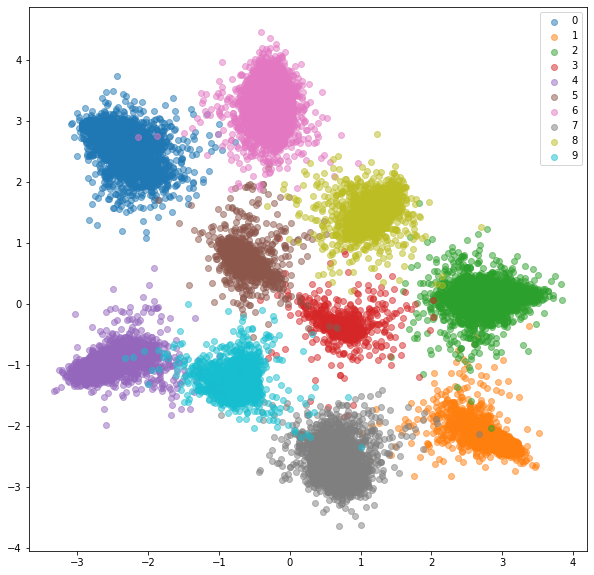

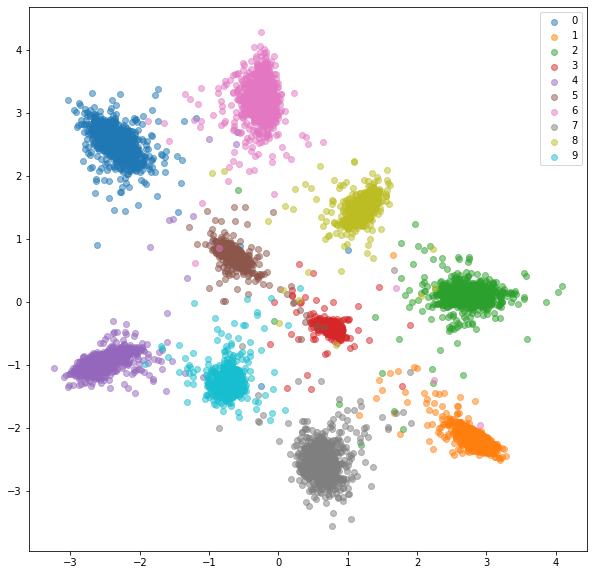

In [27]:
from plotExtract import plot_features, extract_features

train_features, train_labels = extract_features(train_loader, model)
plot_features(train_features, train_labels)
val_features, val_labels = extract_features(test_loader, model)
plot_features(val_features, val_labels)